# Finding Effective Diffusivity and Tortuosity of a Network

In this example we show how to find the effective diffusivity and torutousity of a cubic network. A similar procedure can be used on more complicated extracted networks from Porespy. The effective diffusivity is defined as the diffusion coefficient multiplied by the porosity and divided by the tortuosity. 

$$
D_{AB} = D_{eff}\frac{\epsilon}{\tau}\\
$$

The tortuosity is an attempt to correct for the windy path of matter moving through a porous substance. The classical definition is the actual length divided by the direct length.  In reality, there are many actual pathways that matter could move through. This means that the actual length should more precisely be thought of as the average path length.

$$
{\tau} = (\frac{L_{actual}}{L_{direct}})^2\\
$$

In [1]:
import openpnm as op
import matplotlib.pyplot as plt
import numpy as np

op.visualization.set_mpl_style()
np.random.seed(10)
%matplotlib inline
np.set_printoptions(precision=5)

## Network

For this example we generate a `cubic` network.

In [2]:
shape = [10, 10, 1]
spacing = 1e-5
net = op.network.Cubic(shape=shape, spacing=spacing)

## Geometry

Next, we need to add geometry models to the generated network. OpenPNM has collections of geometry models ready to add to the network object. Choosing the right geometry models is important to represent the microstructure of different materials such as Toray090 carbon papers, sand stone, electrospun fibers, etc. For now, we will use a simple collection of geometry models for a spheres_and_cylinders geometry. These geometry models assume pores are spheres and throats are cylinders.

In [3]:
geo = op.models.collections.geometry.spheres_and_cylinders
net.add_model_collection(geo, domain='all')
net.regenerate_models()

A collection of geometry models should now be added to the network object. Make sure to `regenerate_models` after adding any new models to the network. To view the models that have been added to the network object print the network as follows. Notice how `throat.diameter` and `pore.volume` as well as other shape factor models have been added to the network.

In [4]:
print(net)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x1bb3553c630>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.coordination_number                                        100 / 100
  2  pore.coords                                                     100 / 100
  3  pore.diameter                                                   100 / 100
  4  pore.max_size                                                   100 / 100
  5  pore.seed                                                       100 / 100
  6  pore.volume                                                     100 / 100
  7  throat.conns                                                    180 / 180
  8  throat.cross_sectional_area                                     180 / 180
  9 

## Phase

Now we add a phase object to our simulation. A phase object contains thermophysical information about the working fluid in the simulation. For this simulation, we will use air as our working fluid. `OpenPNM` has other built-in phase objects to choose from.

In [5]:
air = op.phase.Air(network=net)

## Physics

Next we need to add physics models to the phase object. Here we add the `basic` collection of physics models. This includes a `diffusive_conductance` model which we will need for our fickian diffusion simulation. It is easy to remove any physics models you don't need such as `throat.entry_pressure`.

In [6]:
phys = op.models.collections.physics.basic
del phys['throat.entry_pressure']
air.add_model_collection(phys)
air.regenerate_models()

## Performing Fickian Diffusion

Now that everything's set up, it's time to perform our Fickian diffusion simulation. For this purpose, we need to add the `FickianDiffusion` algorithm to our simulation. Here's how we do it:

In [7]:
fd = op.algorithms.FickianDiffusion(network=net, phase=air)

Note that network and phase are required parameters for pretty much every algorithm we add, since we need to specify on which network and for which phase we want to run the algorithm.

In [8]:
inlet = net.pores('left')
outlet = net.pores('right')
C_in, C_out = [10, 5]
fd.set_value_BC(pores=inlet, values=C_in)
fd.set_value_BC(pores=outlet, values=C_out)

Now, it's time to run the algorithm. This is done by calling the run method attached to the algorithm object.

In [9]:
fd.run();

## Visualize the Results

Now that we know the quantity for which `FickianDiffusion` was solved, let's take a look at the results. We use the `plot_coordinates` and `plot_connections` available under visualization. Throat data is interpolated from pore data.

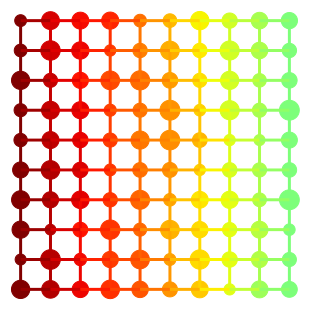

In [10]:
pc = fd['pore.concentration']
tc = fd.interpolate_data(propname='throat.concentration')
d = net['pore.diameter']
fig, ax = plt.subplots(figsize=[5, 5])
op.visualization.plot_coordinates(network=net, color_by=pc, size_by=d, markersize=400, ax=ax)
op.visualization.plot_connections(network=net, color_by=tc, linewidth=3, ax=ax)
_ = plt.axis('off')

## Calculate the Effective Diffusivity

We can determine the effective diffusivity of the network by solving Fick's law as shown below.

$$ D_{eff} = \frac{N_A L}{ A \Delta C} $$

To determine the molar flow rate we can use the `rate` method attached to the algorithm object. The molar flow rate going through the boundary pores at the inlet is calculated. This gives the molar flow rate in units of moles per second. 

In [11]:
rate_inlet = fd.rate(pores=inlet)[0]
print(f'Molar flow rate: {rate_inlet:.5e} mol/s')

Molar flow rate: 3.88846e-11 mol/s


Now let's calculate the effective diffusivity

In [12]:
A = (shape[1] * shape[2])*(spacing**2)
L = shape[0]*spacing
D_eff = rate_inlet * L / (A * (C_in - C_out))
print("{0:.6E}".format(D_eff))

7.776925E-07


## Calculate the Tortuosity

Tortuosity is most easily determined as a fitting factor to transport data. We can use the effective diffusivity measured from the fickian diffusion simulation and the known diffusivity of air to solve for the tortuosity.

$$ \tau = \varepsilon \frac{ D_{AB}}{D_{eff}} $$

But first the porosity of the network must be calculated. Here is how we can calculate the porosity. For more information on how to measure the porosity please refer to the porosity notebook.

In [13]:
V_p = net['pore.volume'].sum()
V_t = net['throat.volume'].sum()
V_bulk = np.prod(shape)*(spacing**3)
e = (V_p + V_t) / V_bulk
print('The porosity is: ', "{0:.6E}".format(e))

The porosity is:  8.429901E-02


In [14]:
D_AB = air['pore.diffusivity'][0]
tau = e * D_AB / D_eff
print('The tortuosity is:', "{0:.6E}".format(tau))

The tortuosity is: 2.270571E+00
